In [205]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread
from tqdm import tqdm_notebook, tnrange
import cv2
from glob import glob
import pickle
import peakutils
from scipy import signal
import imageio
from moviepy.editor import VideoFileClip, ipython_display
from IPython.display import HTML

%matplotlib inline

In [206]:
ROWS = 6
COLS = 9
CAL_IMAGE_SIZE = (720, 1280, 3)
CALC_CAL_POINTS = False
CAL_IMAGE_PATH = 'camera_cal/calibration*.jpg'
CALIBRATION_PATH = 'camera_cal/calibration.p'

def calculate_camera_calibration(path_pattern, rows, cols, image_size):
    """
    Caluculates the camera calibration based in chessboard images. 
    """
    objp = np.zeros((rows*cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)

    objpoints = []
    imgpoints = []

    images = glob(path_pattern)
    cal_images = np.zeros((len(images), *CAL_IMAGE_SIZE), dtype=np.uint8)

    successfull_cnt = 0
    for idx, fname in enumerate(tqdm_notebook(images, desc='Processing image')):
        img = imread(fname)
        if img.shape[0] != CAL_IMAGE_SIZE[0] or img.shape[1] != CAL_IMAGE_SIZE[1]:
            img = imresize(img, CAL_IMAGE_SIZE)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None) 

        if ret == True:
            successfull_cnt +=1

            objpoints.append(objp)
            imgpoints.append(corners)

            img = cv2.drawChessboardCorners(img, (cols, rows), corners, ret)
            cal_images[idx] = img

    print("%s/%s camera calibration images processed." % (successfull_cnt,len(images)))
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, CAL_IMAGE_SIZE[:-1], None, None)
    
    calibration = {'objpoints': objpoints,
                   'imgpoints': imgpoints,
                   'cal_images': cal_images,
                   'mtx': mtx,
                   'dist': dist,
                   'rvecs': rvecs,
                   'tvecs': tvecs}
    
    return calibration

def get_camera_calibration():
    """
    Depending on the constant CALC_CAL_POINTS the camera calibration will be
    calculated and stored on disk or loaded.
    """
    if CALC_CAL_POINTS:
        calibration = calculate_camera_calibration(CAL_IMAGE_PATH, ROWS, COLS, CAL_IMAGE_SIZE)
        with open(CALIBRATION_PATH, 'wb') as f:
            pickle.dump(calibration, file=f)
    else:
        with open(CALIBRATION_PATH, "rb" ) as f:
            calibration = pickle.load(f)
            
    return calibration;

In [207]:
def cal_undistort(img, calibration):
    """
    Takes an image and a calibration object and returns the undistorted image.
    """
    objpoints = calibration['objpoints']
    imgpoints = calibration['imgpoints']
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def img_to_float(img):
    img = img.astype(np.float32)
    img = img / 255
    return img

def abs_sobel_thresh(img_ch, orient='x', sobel_kernel=3, thresh=(0., 1.)):  
    if orient == 'x':
        axis = (1, 0)
    elif orient == 'y':
        axis = (0, 1)
    else:
        raise ValueError('orient has to be "x" or "y" not "%s"' % orient)
    
    sobel = cv2.Sobel(img_ch, cv2.CV_64F, *axis)
    abss = np.absolute(sobel)
    
    binary_output = np.zeros_like(abss)
    binary_output[(abss > thresh[0]) & (abss < thresh[1])] = 1
    
    return binary_output


def mag_thresh(img_ch, sobel_kernel=3, thresh=(0., 1.)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_grad_mag = np.sqrt(sobelx**2+sobely**2)

    mag_binary = np.zeros_like(abs_grad_mag)
    mag_binary[(abs_grad_mag > thresh[0]) & (abs_grad_mag < thresh[1])] = 1.

    return mag_binary


def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    with np.errstate(divide='ignore', invalid='ignore'):
        abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
        max_val = np.nanmax(abs_grad_dir)
        abs_grad_dir[np.isnan(abs_grad_dir)] = max_val 
        dir_binary =  np.zeros_like(abs_grad_dir)
        abs_grad_dir = abs_grad_dir/max_val
        dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary

def equalize_luminance(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    l = img[:,:,2]
    blur = gaussian_blur(l, 35)
    blur = 1. - blur
    img[:,:,2] = (l + blur) / 2
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    
    return img


def colorspace_channel_select(img, cs, ch, thresh=(0, 255)):
    cs_img = cv2.cvtColor(img, cs)
    s_ch = cs_img[:,:,ch]
    retval, ch_binary = cv2.threshold(s_ch.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)

    return ch_binary


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def adjust_gamma(image, gamma=1.0):
    was_float = False
    if image.dtype == np.float32:
        was_float = True
        image = img_to_int(image)
    
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    image = cv2.LUT(image, table)
    
    if was_float:
        image = img_to_float(image)
    
    return image

def push_higlights(img, thres=.8):
    img[img > thres] = 1
    return img

def extract_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (30., 0.4, 0.4), (70., 1., 1.))
    
    return mask

def extract_white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0, 0, 0.8), (360., 0.1, 1.))
    
    return mask

def get_thresholded_image(img):
    img = equalize_luminance(img)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = np.mean(img, 2)

    x = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0.05, .4))
    y = abs_sobel_thresh(gray, orient='y', sobel_kernel=3, thresh=(0.05, .2))

    x_mul_y = x * y
    x_mul_y = gaussian_blur(x_mul_y, 11)

    dir = dir_threshold(gray, sobel_kernel=3, thresh=(0.4, 0.8))
    dir = gaussian_blur(dir, 11)
    mag = mag_thresh(gray, 3, thresh=(0.05, 0.5))
    mag = gaussian_blur(mag, 11)

    dir_mul_mag = dir * mag

    comb = x_mul_y + dir_mul_mag
    comb = comb / comb.max()
    
    wht = extract_white(img)
    ylw = extract_yellow(img)
 
    img = np.dstack([comb, wht, ylw])
    img = np.max(img, axis=2)
    
    return img


class PerspectiveTransformer():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)

    def transform(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def inverse_transform(self, img):
        return cv2.warpPerspective(img, self.M_inv, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

def histogram_lane_detection(img, steps, search_window, h_window, v_window):
    # TODO add dynamic search window. Grows if detected peaks get close to border.
    all_x = []
    all_y = []
    masked_img = img[:, search_window[0]:search_window[1]]
    histograms = np.zeros((steps, masked_img.shape[1]))
    pixels_per_step = img.shape[0]//steps
    
    for i in range(steps):    
        start = masked_img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        histogram = np.sum(masked_img[end:start,:], axis=0)
        histograms[i] = histogram
    
    histograms = histogram_smoothing(histograms, window=v_window)
    
    for i, histogram in enumerate(histograms):
        start = masked_img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        
        histogram_smooth = signal.medfilt(histogram, h_window)        
        peaks = np.array(signal.find_peaks_cwt(histogram_smooth, np.arange(1, 50)))
        
        highest_peak = detect_highest_peak_in_area(histogram_smooth, peaks, threshold=1000)
        if highest_peak is not None:
            center = (start + end)//2
            x, y = get_pixel_in_window(masked_img, highest_peak, center, pixels_per_step)

            all_x.extend(x)
            all_y.extend(y)
    
    all_x = np.array(all_x) + search_window[0]
    all_y = np.array(all_y)

    return all_x, all_y

def highest_n_peaks(histogram, peaks, n=2, threshold=0):
    if len(peaks) == 0:
        return []
    
    peak_list = []
    for peak in peaks:
        y = histogram[peak]
        if y > threshold:
            peak_list.append((peak, histogram[peak]))   
    peak_list = sorted(peak_list, key=lambda x: x[1], reverse=True)

    if len(peak_list) == 0:
        return []
    else:
        x, y = zip(*peak_list)
        return x[:n]

def histogram_smoothing(histograms, window=3):
    smoothed = np.zeros_like(histograms)
    for h_i, hist in enumerate(histograms):
        window_sum = np.zeros_like(hist)
        for w_i in range(window):
            index = w_i + h_i - window//2
            if index < 0:
                index = 0
            elif index > len(histograms) - 1:
                index = len(histograms) - 1
            
            window_sum += histograms[index]
        
        smoothed[h_i] = window_sum / window
        
    return smoothed

def detect_highest_peak_in_area(histogram, peaks, threshold=0):
    peak = highest_n_peaks(histogram, peaks, n=1, threshold=threshold)
    if len(peak) == 1:
        return peak[0]
    else: 
        return None

def detect_lane_along_poly(img, poly, steps):
    pixels_per_step = img.shape[0]//steps
    all_x = []
    all_y = []
    
    for i in range(steps):
        start = img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        
        center = (start + end)//2
        x = poly(center)
        
        x, y = get_pixel_in_window(img, x, center, pixels_per_step)
        
        all_x.extend(x)
        all_y.extend(y)
        
    return all_x, all_y

def get_pixel_in_window(img, x_center, y_center, size):
    half_size = size//2
    window = img[y_center-half_size:y_center+half_size,
                 x_center-half_size:x_center+half_size]
    
    x, y = (window.T==255).nonzero()

    x = x + x_center-half_size
    y = y + y_center-half_size
    
    return x, y

def calculate_lane_area(lanes, img_height, steps):
    """
    Expects the line polynom to be a function of y.
    """
    points_left = np.zeros((steps + 1, 2))
    points_right = np.zeros((steps + 1, 2))

    for i in range(steps + 1):
        pixels_per_step = img_height//steps
        start = img_height - i * pixels_per_step

        points_left[i] = [lanes[0].best_fit_poly(start), start]
        points_right[i] = [lanes[1].best_fit_poly(start), start]

    return np.concatenate((points_left, points_right[::-1]), axis=0)

def are_lanes_plausible(lane_one, lane_two, parall_thres=(0.0003, 0.55), dist_thres=(400, 600)):    
    is_parall = lane_one.is_current_fit_parallel(lane_two, threshold=parall_thres)
    dist = lane_one.get_current_fit_distance(lane_two)
    is_plausible_dist = dist_thres[0] < dist < dist_thres[1]

    return is_parall & is_plausible_dist


def draw_poly(img, poly, steps, color, thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height//steps    
    
    for i in range(steps):    
        start = i * pixels_per_step
        end = start + pixels_per_step
        
        start_point = (int(poly(start)), start)
        end_point = (int(poly(end)), end)
        
        if dashed == False or i%2==1: 
            img = cv2.line(img, end_point, start_point, color, thickness)
    
    return img

def draw_poly_arr(img, poly, steps, color, thickness=10, dashed=False, tipLength=1):
    img_height = img.shape[0]
    pixels_per_step = img_height//steps    
    
    for i in range(steps):    
        start = i * pixels_per_step
        end = start + pixels_per_step
        
        start_point = (int(poly(start)), start)
        end_point = (int(poly(end)), end)
        
        if dashed == False or i%2==1: 
            img = cv2.arrowedLine(img, end_point, start_point, color, thickness, tipLength=tipLength)
    
    return img

def outlier_removal(x, y, q=10):
    if len(x) == 0 or len(y) == 0:
        return x, y
    
    x = np.array(x)
    y = np.array(y)

    lower_bound = np.percentile(x, q)
    upper_bound = np.percentile(x, 100-q)
    selection = (x >= lower_bound) & (x <= upper_bound)
    return x[selection], y[selection]

def calc_curvature(fit_cr):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    
    y = np.array(np.linspace(0, 719, num=10))
    x = np.array([fit_cr(x) for x in y])
    y_eval = np.max(y)

    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])

    return curverad 

In [208]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n_frames=1, x=None, y=None):
        # Frame memory
        self.n_frames = n_frames
        # was the line detected in the last iteration?
        self.detected = False
        # number of pixels added per frame
        self.n_pixel_per_frame = []
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #Polynom for the current coefficients
        self.current_fit_poly = None
        #Polynom for the average coefficients over the last n iterations
        self.best_fit_poly = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        if x is not None:
            self.update(x, y)
        
    def update(self, x, y):
        assert len(x) == len(y), 'x and y have to be the same size'
        
        self.allx = x
        self.ally = y
        
        self.n_pixel_per_frame.append(len(self.allx))
        self.recent_xfitted.extend(self.allx)
        
        if len(self.n_pixel_per_frame) > self.n_frames:
            n_x_to_remove = self.n_pixel_per_frame.pop(0)
            self.recent_xfitted = self.recent_xfitted[n_x_to_remove:]
        
        self.bestx = np.mean(self.recent_xfitted)
        
        self.current_fit = np.polyfit(self.allx, self.ally, 2)
        
        if self.best_fit is None:
            self.best_fit = self.current_fit
        else:
            self.best_fit = (self.best_fit * (self.n_frames - 1) + self.current_fit) / self.n_frames
            
        self.current_fit_poly = np.poly1d(self.current_fit)
        self.best_fit_poly = np.poly1d(self.best_fit)

    
    def is_current_fit_parallel(self, other_line, threshold=(0, 0)):        
        first_coefi_dif = np.abs(self.current_fit[0] - other_line.current_fit[0])
        second_coefi_dif = np.abs(self.current_fit[1] - other_line.current_fit[1])

        is_parallel = first_coefi_dif < threshold[0] and second_coefi_dif < threshold[1]

        return is_parallel
        
    def get_current_fit_distance(self, other_line):
        return np.abs(self.current_fit_poly(719) - other_line.current_fit_poly(719))
    
    def get_best_fit_distance(self, other_line):
        return np.abs(self.best_fit_poly(719) - other_line.best_fit_poly(719))

In [209]:
HIST_STEPS = 10
OFFSET = 200
SRC = np.float32([
    (300, 720),
    (580, 470),
    (730, 470),
    (1100, 720)])


DST = np.float32([
    (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
    (SRC[0][0] - 50 + OFFSET, 0),
    (SRC[-1][0] - OFFSET, 0),
    (SRC[-1][0] - OFFSET, SRC[0][1])])

FRAME_MEMORY = 5

class LaneDetector():
    def __init__(self, perspective_src, perspective_dst, n_frames=1, cam_calibration=None, line_segments=10):
        # Frame memory
        self.n_frames = n_frames
        self.cam_calibration = cam_calibration
        self.line_segments = line_segments

        self.left_line = None
        self.right_line = None
        self.center_poly = None
        self.curvature = 0.0
        self.offset = 0.0
        
        self.perspective_src = perspective_src
        self.perspective_dst = perspective_dst
        self.perspective_transformer = PerspectiveTransformer(perspective_src, perspective_dst)
        
        self.n_frames_processed = 0
        self.dists = []
    
    def __line_found(self, left, right):
        if len(left[0]) == 0 or len(right[0]) == 0:
            return False
        else:
            new_left = Line(y=left[0], x=left[1])
            new_right = Line(y=right[0], x=right[1])
            return are_lanes_plausible(new_left, new_right)
        
    def __draw_info_panel(self, img):
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, 'Radius of Curvature = %d(m)' % self.curvature, (50,50), font, 1,(1.,1.,1.),2)
        left_or_right = 'left' if self.offset < 0 else 'right'
        cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(self.offset), left_or_right), (50,100), font, 1,(1.,1.,1.),2)
        
    def __draw_lane_overlay(self, img):
        overlay = np.zeros([*img.shape])
        mask = np.zeros([img.shape[0], img.shape[1]])

        lane_area = calculate_lane_area((self.left_line, self.right_line), img.shape[0], 20)
        mask = cv2.fillPoly(mask, np.int32([lane_area]), 1)
        mask = self.perspective_transformer.inverse_transform(mask)

        overlay[mask == 1] = (1., 0.5, 0)
        selection = (overlay != 0)
        img[selection] = img[selection] * 0.3 + overlay[selection] * 0.7     

        center_line = np.zeros([img.shape[0], img.shape[1]])
        center_line = draw_poly_arr(center_line, self.center_poly, 20, 1., 5, True, tipLength=0.5)
        center_line = self.perspective_transformer.inverse_transform(center_line)
        img[center_line == 1.] = (1., 0.3, 0.01)

        lines_best = np.zeros([img.shape[0], img.shape[1]])
        lines_best = draw_poly(lines_best, self.left_line.best_fit_poly, 5, 1.)
        lines_best = draw_poly(lines_best, self.right_line.best_fit_poly, 5, 1.)
        lines_best = self.perspective_transformer.inverse_transform(lines_best)
        img[lines_best == 1.] = (1., 0.8, 0.01)
        
    def __detect_line(self, img, line, window):
        line_detected = False
        if self.n_frames_processed != 0:
            x, y = detect_lane_along_poly(frame, line.best_fit_poly, self.line_segments)

            if self.__line_found((x, y), (line.ally, line.allx)):
                line_detected = True

        if line_detected == False:
            x, y = histogram_lane_detection(frame, self.line_segments, window, h_window=21, v_window=3)

        if self.__line_found((x, y), (line.ally, line.allx)):
            line_detected = True

        if line_detected == True:
            return x, y
        else:
            return None

    def process_frame(self, frame):
        frame = img_to_float(frame)
        orig_frame = np.copy(frame)
        
        # Apply the distortion correction to the raw image.
        if self.cam_calibration is not None:
            frame = cal_undistort(frame, self.cam_calibration)
    
        # Use color transforms, gradients, etc., to create a thresholded binary image.
        frame = gaussian_blur(frame, kernel_size=5)
        frame = get_thresholded_image(frame)
        
        # Apply a perspective transform to rectify binary image ("birds-eye view").
        frame = self.perspective_transformer.transform(frame)


        # mask outside are of persp trans
        frame[:, frame.shape[1]-OFFSET:] = 0
        frame[:, :OFFSET] = 0

        left_detected = False
        right_detected = False
        if self.n_frames_processed != 0 and self.left_line is not None and self.right_line is not None:
            left_x, left_y = detect_lane_along_poly(frame, self.left_line.best_fit_poly, self.line_segments)
            right_x, right_y = detect_lane_along_poly(frame, self.right_line.best_fit_poly, self.line_segments)
            left_x, left_y = outlier_removal(left_x, left_y)
            right_x, right_y = outlier_removal(right_x, right_y)

            if self.__line_found((left_x, left_y), (right_x, right_y)):
                left_detected = True
                right_detected = True
            elif self.left_line is not None and self.right_line is not None:
                if self.__line_found((left_x, left_y), (self.left_line.ally, self.left_line.allx)):
                    left_detected = True
                if self.__line_found((right_x, right_y), (self.right_line.ally, self.right_line.allx)):
                    right_detected = True

        if left_detected == False:
            left_x, left_y = histogram_lane_detection(
                frame, self.line_segments, (OFFSET, frame.shape[1]//2), h_window=21, v_window=3)
            left_x, left_y = outlier_removal(left_x, left_y)
        if right_detected == False:
            right_x, right_y = histogram_lane_detection(
                frame, self.line_segments, (frame.shape[1]//2, frame.shape[1] - OFFSET), h_window=21, v_window=3)
            right_x, right_y = outlier_removal(right_x, right_y)


        if self.__line_found((left_x, left_y), (right_x, right_y)):
            left_detected = True
            right_detected = True
        elif self.left_line is not None and self.right_line is not None:
            if self.__line_found((left_x, left_y), (self.left_line.ally, self.left_line.allx)):
                left_detected = True
            if self.__line_found((right_x, right_y), (self.right_line.ally, self.right_line.allx)):
                right_detected = True

        if left_detected == True:
            # switch x and y since lines are almost vertical
            if self.left_line is not None:
                self.left_line.update(y=left_x, x=left_y)
            else:
                self.left_line = Line(self.n_frames, left_y, left_x)

        if right_detected == True:
            # switch x and y since lines are almost vertical
            if self.right_line is not None:
                self.right_line.update(y=right_x, x=right_y)
            else:
                self.right_line = Line(self.n_frames, right_y, right_x)

        if self.left_line is not None and self.right_line is not None:
            self.dists.append(self.left_line.get_best_fit_distance(self.right_line))
            self.center_poly = (self.left_line.best_fit_poly + self.right_line.best_fit_poly) / 2
            self.curvature = calc_curvature(self.center_poly)
            self.offset = (frame.shape[1]/2 - self.center_poly(719)) * 3.7/700
            

            self.__draw_lane_overlay(orig_frame)
            self.__draw_info_panel(orig_frame)

        self.n_frames_processed += 1
        return img_to_int(orig_frame)


        plt.scatter(left_x,left_y, color='b')
        plt.scatter(right_x,right_y, color='r')

        return frame

In [210]:
def img_to_int(img):
    return (img * 255).astype(np.uint8)

def extract_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (30., 0.3, 0.3), (70., 1., 1.))
    
    return mask

def extract_white(img):
    thresh = 0.80 - (1-np.percentile(img, 99.9))
    mask = cv2.inRange(img, (thresh, thresh, thresh), (1., 1., 1.))
    
    return mask

def extract_darks(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (0, 0, 0.), (360., 0.6, 0.5))
    
    return mask

In [211]:
def get_thresholded_image(img):
    #img = equalize_luminance(img)

    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    gray = np.mean(yuv[:,:,1:2], 2)

    x = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0.05, .4))
    y = abs_sobel_thresh(gray, orient='y', sobel_kernel=3, thresh=(0.05, .2))

    x_mul_y = x * y
    x_mul_y = gaussian_blur(x_mul_y, 11)

    dir = dir_threshold(gray, sobel_kernel=3, thresh=(0.4, 0.8))
    dir = gaussian_blur(dir, 11)
    mag = mag_thresh(gray, 3, thresh=(0.05, 0.5))
    mag = gaussian_blur(mag, 11)

    dir_mul_mag = dir * mag

    comb = x_mul_y + dir_mul_mag
    comb = comb / comb.max()
    comb = cv2.inRange(comb, 0.3, 1.)
    
    wht = extract_white(img)
    ylw = extract_yellow(img)
    darks = extract_darks(img)
 
    img = np.dstack([comb, wht, ylw])
    img = np.max(img, axis=2)
    img[darks == 255] = 0
    
    return img

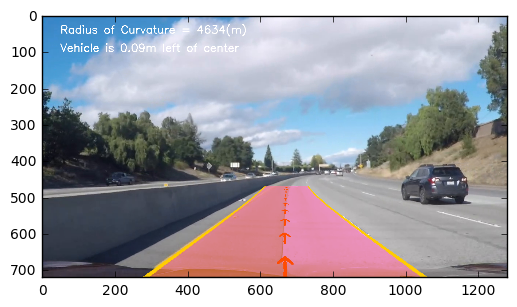

In [212]:
cam_calibration = get_camera_calibration()
img = imread('test_images/test15.jpg')
ld = LaneDetector(SRC, DST, n_frames=FRAME_MEMORY, cam_calibration=cam_calibration)
img = ld.process_frame(img)
plt.imshow(img, cmap='gray')

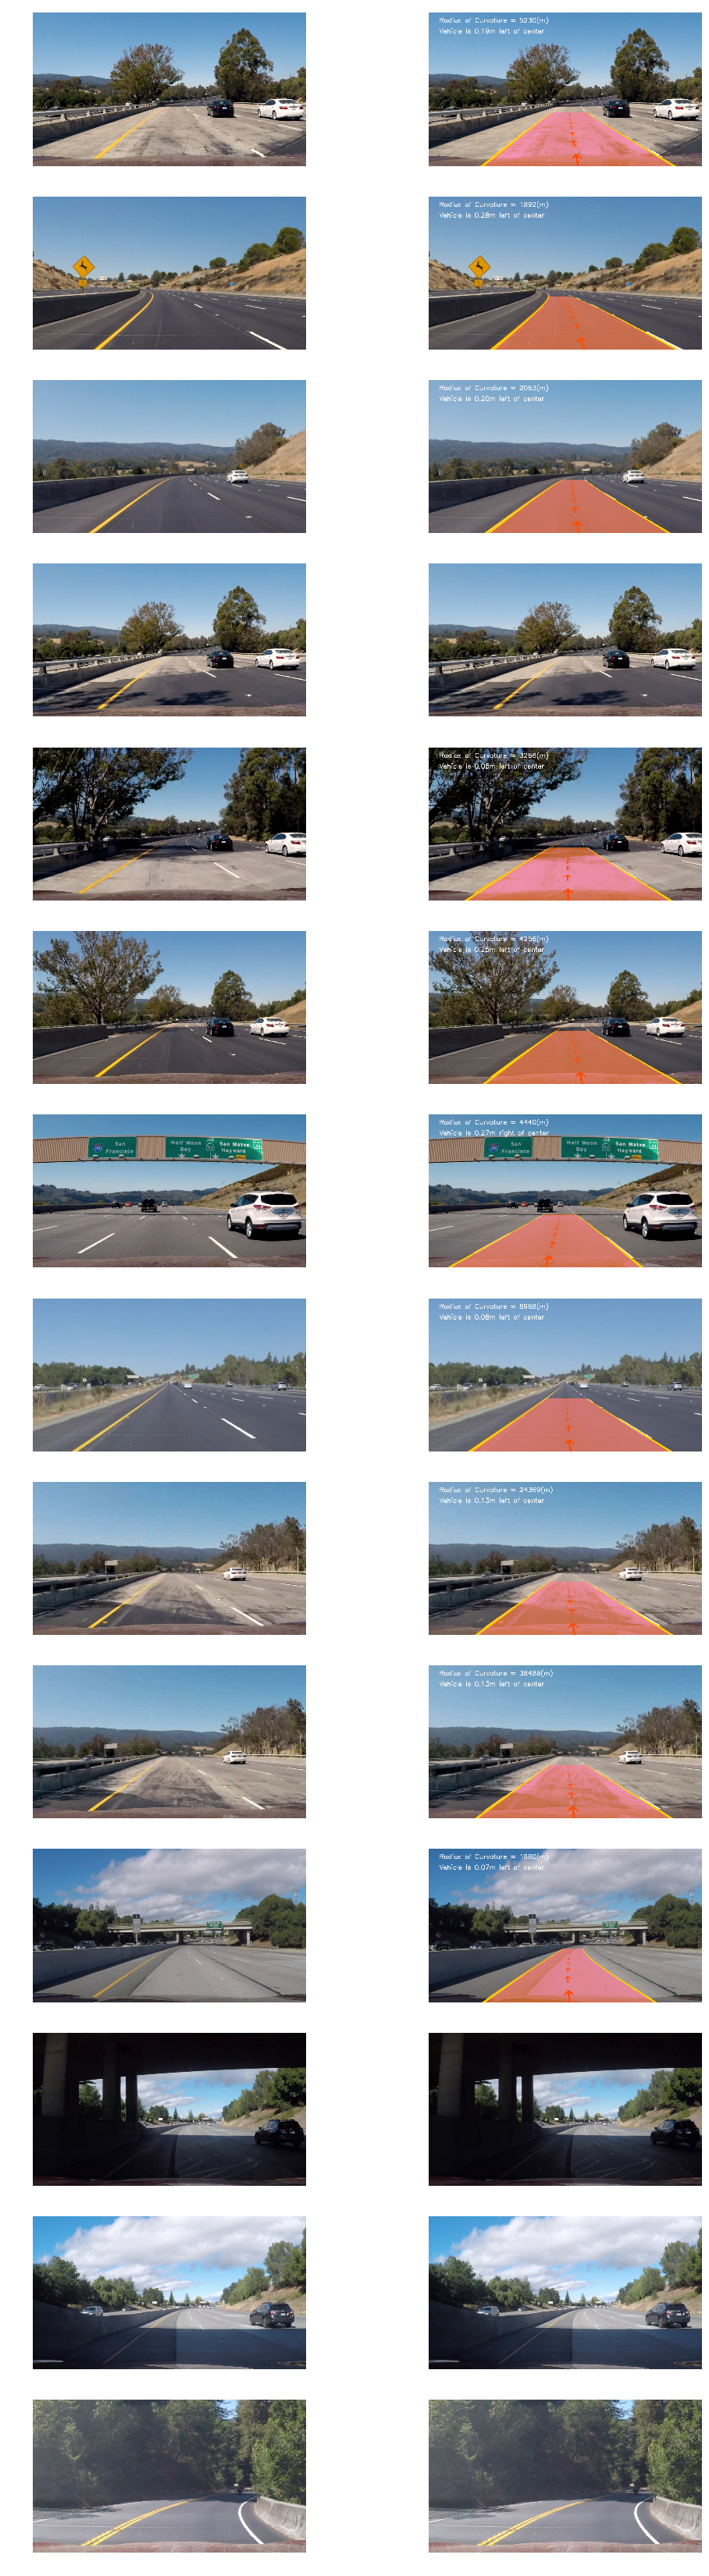

In [213]:
images = []
for i in range(1, 15):
    images.append(imread('test_images/test%s.jpg' % i))
    
cam_calibration = get_camera_calibration()
rows=len(images)
cols=2
fig, axis = plt.subplots(rows, cols, figsize=(12, 3*rows))
for row in range(rows):
    img = images[row]

    axis[row, 0].imshow(img, cmap='gray')
    axis[row, 0].axis('off')
    
    ld = LaneDetector(SRC, DST, n_frames=FRAME_MEMORY, cam_calibration=cam_calibration)
    try:
        img = ld.process_frame(img)
    except:
        img= img
    axis[row, 1].imshow(img, cmap='gray')
    axis[row, 1].axis('off')

In [214]:
cam_calibration = get_camera_calibration()
ld = LaneDetector(SRC, DST, n_frames=FRAME_MEMORY, cam_calibration=cam_calibration)

project_output = 'project_video_ann.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(ld.process_frame)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_ann.mp4
[MoviePy] Writing video project_video_ann.mp4


100%|█████████▉| 1260/1261 [20:43<00:01,  1.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_ann.mp4 

CPU times: user 35min 43s, sys: 44.9 s, total: 36min 28s
Wall time: 20min 44s


In [215]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [216]:
cam_calibration = get_camera_calibration()
ld = LaneDetector(SRC, DST, n_frames=FRAME_MEMORY, cam_calibration=cam_calibration)

project_output = 'challenge_video_ann.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
project_clip = clip1.fl_image(ld.process_frame)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video challenge_video_ann.mp4
[MoviePy] Writing video challenge_video_ann.mp4


100%|██████████| 485/485 [07:26<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_ann.mp4 

CPU times: user 14min 21s, sys: 18.2 s, total: 14min 39s
Wall time: 7min 27s


In [218]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))